In [ ]:
!pip install yargy -qq

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 38.3 MB/s eta 0:00:00


In [ ]:
!pip install pymorphy3  -qq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.9/53.9 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 59.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
import nltk
import re
import string
import numpy as np

import requests
import pickle
import io

from yargy import Parser, rule, and_, not_, or_, forward
from yargy.interpretation import fact
from yargy.relations import gnc_relation
from yargy.predicates import gram, is_capitalized, type, caseless, eq, custom, normalized, dictionary, in_, length_eq
from yargy.pipelines import morph_pipeline

from wordcloud import WordCloud
import pymorphy3

In [ ]:
splits = {'train': 'data/train-00000-of-00001.parquet', 'test': 'data/test-00000-of-00001.parquet', 'dev': 'data/dev-00000-of-00001.parquet'}
df = pd.read_parquet("hf://datasets/surdan/nerel_short/" + splits["train"])
print(df.head())

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


                                           sequences  \
0  [Виталий, Кличко, хочет, стать, мэром, Киева, ...   
1  [Я, хочу, стать, мэром, Киева, так, как, я, оч...   
2  [Виталий, Кличко, был, чемпионом, мира, по, ве...   
3  [преследовавших, его, травм, в, ноябре, 2005, ...   
4  [Подозреваемый, в, гибели, Марины, Голуб, Алек...   

                                                 ids  
0  [44, 45, 0, 0, 48, 5, 0, 3, 4, 0, 0, 0, 0, 0, ...  
1  [0, 0, 0, 48, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
2                        [44, 45, 0, 3, 4, 0, 0, 38]  
3  [0, 0, 0, 11, 12, 12, 12, 0, 0, 0, 48, 0, 0, 1...  
4  [0, 0, 17, 44, 45, 44, 45, 17, 0, 0, 0, 0, 11,...  


In [ ]:
def load_pickle_from_hf(repo_id, filename):
    url = f"https://huggingface.co/datasets/{repo_id}/raw/main/{filename}"

    try:
        response = requests.get(url)
        response.raise_for_status()
        mapper = pickle.load(io.BytesIO(response.content))
        return mapper
    except Exception as e:
        print(f"Ошибка загрузки: {e}")
        return None

mapper = load_pickle_from_hf("surdan/nerel_short", "id_to_label_map.pickle")
mapper

{0: 'O',
 1: 'I-AGE',
 2: 'B-AGE',
 3: 'B-AWARD',
 4: 'I-AWARD',
 5: 'B-CITY',
 6: 'I-CITY',
 7: 'B-COUNTRY',
 8: 'I-COUNTRY',
 9: 'B-CRIME',
 10: 'I-CRIME',
 11: 'B-DATE',
 12: 'I-DATE',
 13: 'B-DISEASE',
 14: 'I-DISEASE',
 15: 'B-DISTRICT',
 16: 'I-DISTRICT',
 17: 'B-EVENT',
 18: 'I-EVENT',
 19: 'B-FACILITY',
 20: 'I-FACILITY',
 21: 'B-FAMILY',
 22: 'I-FAMILY',
 23: 'B-IDEOLOGY',
 24: 'I-IDEOLOGY',
 25: 'B-LANGUAGE',
 26: 'I-LAW',
 27: 'B-LAW',
 28: 'B-LOCATION',
 29: 'I-LOCATION',
 30: 'B-MONEY',
 31: 'I-MONEY',
 32: 'B-NATIONALITY',
 33: 'I-NATIONALITY',
 34: 'B-NUMBER',
 35: 'I-NUMBER',
 36: 'B-ORDINAL',
 37: 'I-ORDINAL',
 38: 'B-ORGANIZATION',
 39: 'I-ORGANIZATION',
 40: 'B-PENALTY',
 41: 'I-PENALTY',
 42: 'B-PERCENT',
 43: 'I-PERCENT',
 44: 'B-PERSON',
 45: 'I-PERSON',
 46: 'I-PRODUCT',
 47: 'B-PRODUCT',
 48: 'B-PROFESSION',
 49: 'I-PROFESSION',
 50: 'B-RELIGION',
 51: 'I-RELIGION',
 52: 'B-STATE_OR_PROVINCE',
 53: 'I-STATE_OR_PROVINCE',
 54: 'B-TIME',
 55: 'I-TIME',
 56: 'B-WOR

# Анализ сущностей

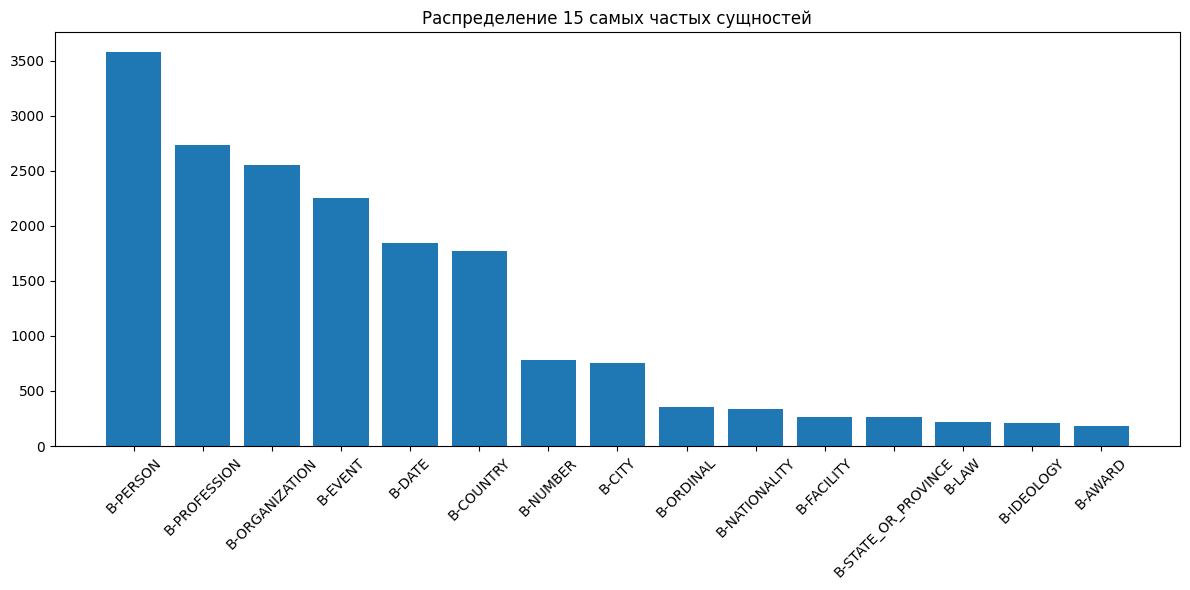

Топ-10 сущностей: [('B-PERSON', 3581), ('B-PROFESSION', 2735), ('B-ORGANIZATION', 2551), ('B-EVENT', 2258), ('B-DATE', 1848), ('B-COUNTRY', 1777), ('B-NUMBER', 786), ('B-CITY', 759), ('B-ORDINAL', 354), ('B-NATIONALITY', 332)]


In [ ]:
def analyze_ner_distribution(sequences_list, mapper):
    all_labels = []
    for sequence in sequences_list:
        for label_id in sequence:
            if label_id != 0 and mapper[label_id].startswith('B-'):
                all_labels.append(mapper[label_id])

    distribution = Counter(all_labels)

    plt.figure(figsize=(12, 6))
    labels, counts = zip(*distribution.most_common(15))
    plt.bar(labels, counts)
    plt.xticks(rotation=45)
    plt.title('Распределение 15 самых частых сущностей')
    plt.tight_layout()
    plt.show()

    return distribution

ner_distribution = analyze_ner_distribution(df['ids'].tolist(), mapper)
print("Топ-10 сущностей:", ner_distribution.most_common(10))

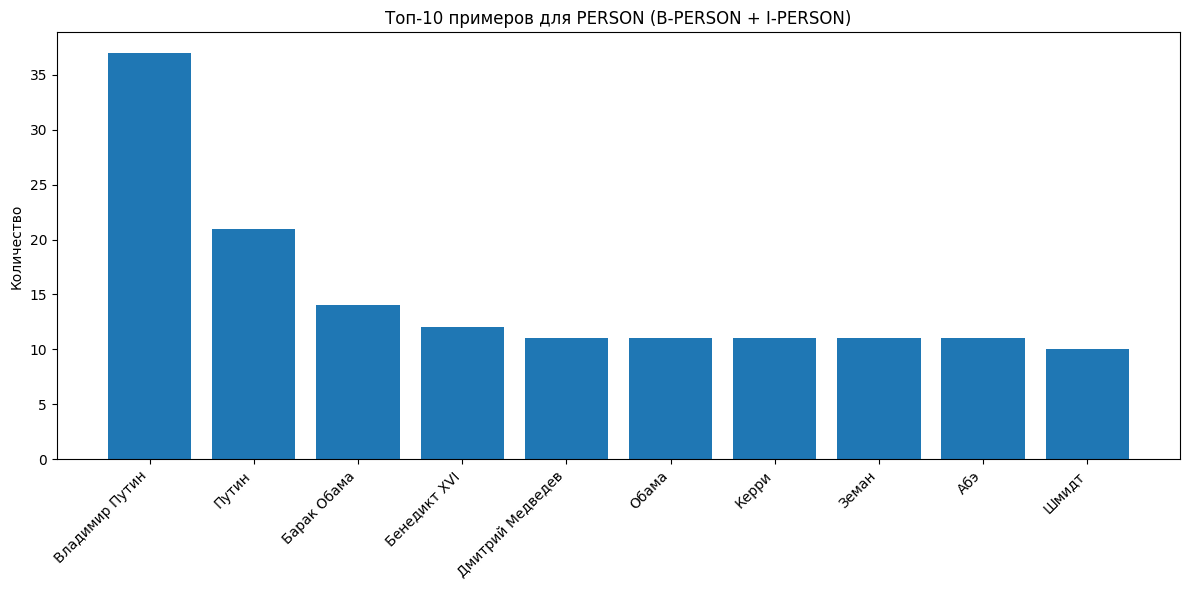

Всего уникальных примеров: 2164


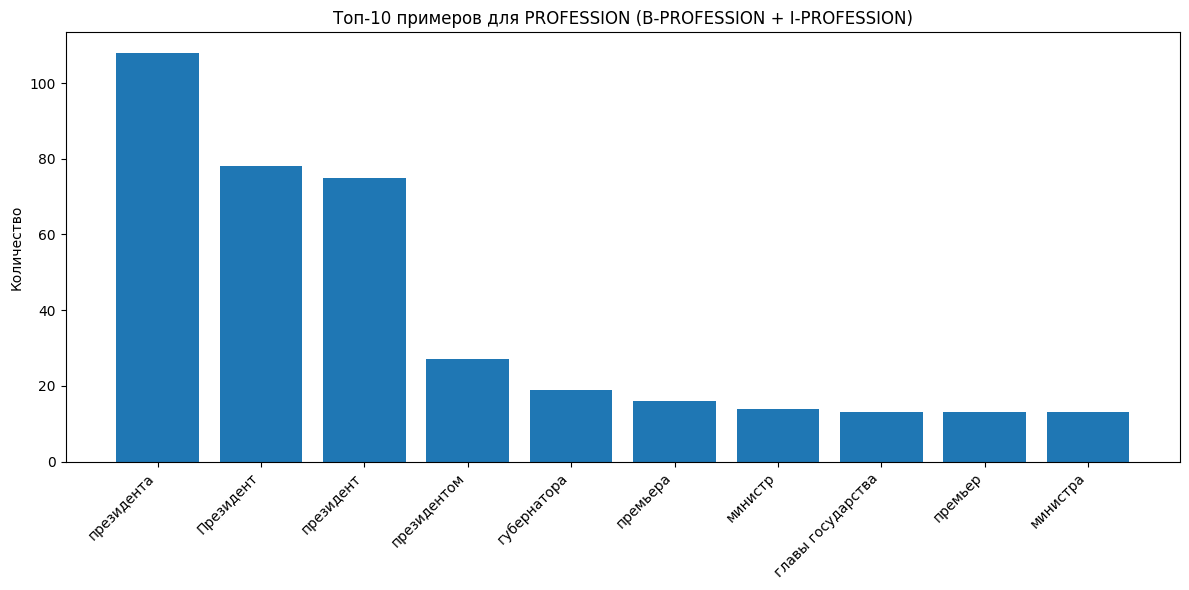

Всего уникальных примеров: 1536


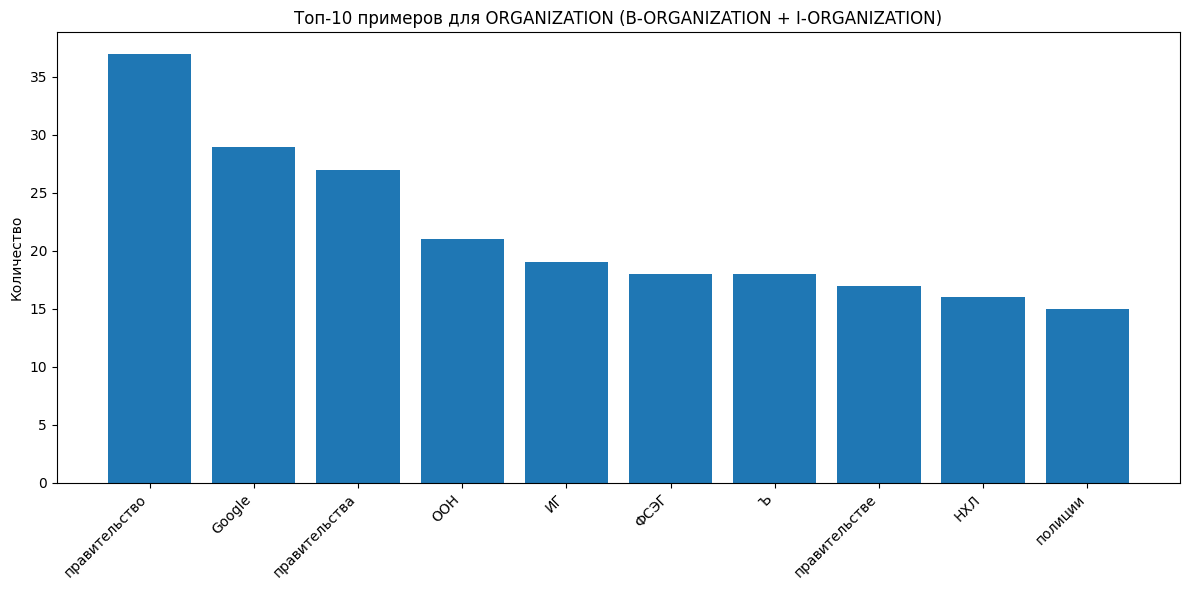

Всего уникальных примеров: 1516


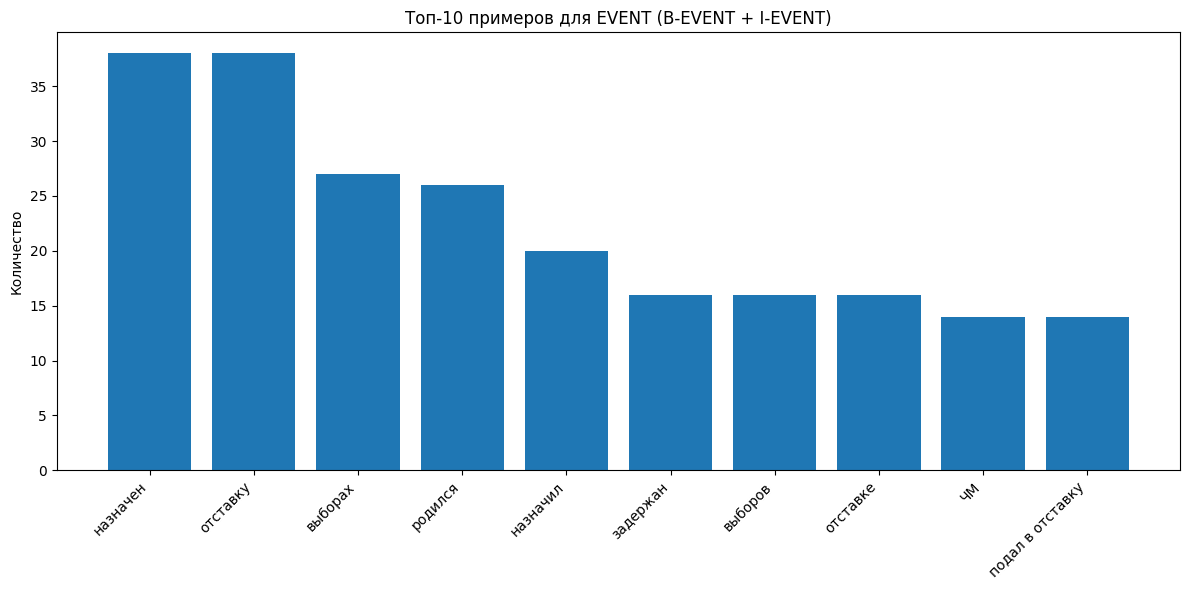

Всего уникальных примеров: 1434


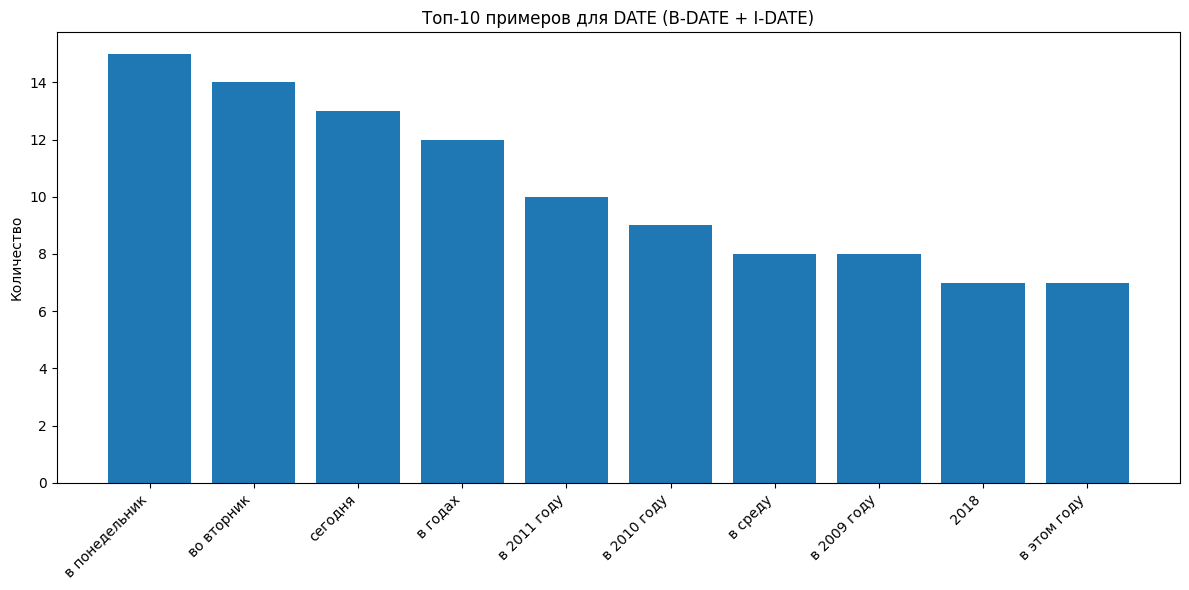

Всего уникальных примеров: 1374


In [ ]:
top_5_entities = [entity for entity, count in ner_distribution.most_common(5)]

for entity in top_5_entities:
    b_entity = entity
    i_entity = 'I-' + entity[2:]

    entity_examples = []

    for idx, row in df.iterrows():
        sequences = row['sequences']
        ids = [int(x) for x in row['ids']]

        current_entity_tokens = []
        for i, (token, entity_id) in enumerate(zip(sequences, ids)):
            entity_name = mapper.get(entity_id, 'O')
            if entity_name == b_entity or entity_name == i_entity:
                current_entity_tokens.append(token)
            elif current_entity_tokens:
                entity_text = ' '.join(current_entity_tokens)
                entity_examples.append(entity_text)
                current_entity_tokens = []

        if current_entity_tokens:
            entity_text = ' '.join(current_entity_tokens)
            entity_examples.append(entity_text)

    example_counts = Counter(entity_examples)

    top_examples = example_counts.most_common(10)

    examples, counts = zip(*top_examples)

    plt.figure(figsize=(12, 6))
    plt.bar(examples, counts)
    plt.title(f'Топ-10 примеров для {entity[2:]} (B-{entity[2:]} + I-{entity[2:]})')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Количество')
    plt.tight_layout()
    plt.show()

    print(f"Всего уникальных примеров: {len(example_counts)}")

# Обработка данных

In [ ]:
nltk.download('stopwords')
russian_stopwords = stopwords.words('russian')

additional_stopwords = ['это', 'как', 'так', 'и', 'в', 'над', 'к', 'до',
                          'не', 'на', 'но', 'за', 'то', 'с', 'ли', 'а', 'во',
                          'от', 'со', 'для', 'о', 'же', 'ну', 'вы', 'бы', 'что',
                          'кто', 'он', 'она', 'также', 'еще', 'ещё', 'её', 'который', 'свой']
russian_stopwords.extend(additional_stopwords)

def remove_punctuation_with_ids(sequence, ids):

    cleaned_sequence = []
    cleaned_ids = []

    for word, word_id in zip(sequence, ids):
        is_potential_entity = (
            word.istitle() or
            word.isupper() or
            any(c.isdigit() for c in word)
        )
        cleaned_word = word
        if not is_potential_entity:
            all_punct = str.maketrans('', '', string.punctuation + '«»—')
            cleaned_word = word.translate(all_punct)

        if cleaned_word:
            cleaned_sequence.append(cleaned_word)
            cleaned_ids.append(word_id)

    return cleaned_sequence, cleaned_ids

def remove_stopwords_with_ids(sequence, ids):
    cleaned_sequence = []
    cleaned_ids = []

    for word, word_id in zip(sequence, ids):
        if word.lower() not in russian_stopwords:
            cleaned_sequence.append(word)
            cleaned_ids.append(word_id)

    return cleaned_sequence, cleaned_ids

def remove_empty_words_with_ids(sequence, ids):
    cleaned_sequence = []
    cleaned_ids = []

    for word, word_id in zip(sequence, ids):
        if word.strip():
            cleaned_sequence.append(word)
            cleaned_ids.append(word_id)

    return cleaned_sequence, cleaned_ids

morph = pymorphy3.MorphAnalyzer()

def lemmatize_sequence(sequence, ids):
    lemmatized_sequence = []
    lemmatized_ids = []

    for word, word_id in zip(sequence, ids):
        is_upper = word.isupper()
        is_title = word.istitle()

        lemma = morph.parse(word)[0].normal_form

        if is_upper:
            lemma = lemma.upper()
        elif is_title:
            lemma = lemma.title()

        lemmatized_sequence.append(lemma)
        lemmatized_ids.append(word_id)

    return lemmatized_sequence, lemmatized_ids

def preprocess_sequence_with_ids(sequence, ids):
    sequence, ids = remove_punctuation_with_ids(sequence, ids)
    sequence, ids = remove_empty_words_with_ids(sequence, ids)
    sequence, ids = lemmatize_sequence(sequence, ids)
    sequence, ids = remove_stopwords_with_ids(sequence, ids)

    return sequence, ids

def preprocess_dataset(df):
    df_processed = df.copy()

    processed_data = []
    for idx, row in df_processed.iterrows():
        sequence = row['sequences']
        ids = row['ids']

        processed_sequence, processed_ids = preprocess_sequence_with_ids(sequence, ids)

        if len(processed_sequence) > 0 and len(processed_ids) > 0:
            processed_data.append({
                'sequences': processed_sequence,
                'ids': processed_ids
            })

    df_processed = pd.DataFrame(processed_data)
    return df_processed.reset_index(drop=True)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


В процессе предобработки мы удаляем стоп-слова, знаки пунктуации и пустые токены. Также делаем лемматизацию с сохранением регистра, т.к. в датасете много имён, стран и т.д., для чего важно учитывать регистр слова.

In [ ]:
df_processed = preprocess_dataset(df)
df_processed.head()

,sequences,ids
0,"[Виталий, Кличко, хотеть, стать, мэр, Киев, Бы...","[44, 45, 0, 0, 48, 5, 0, 3, 4, 0, 0, 0, 44, 45..."
1,"[хотеть, стать, мэр, Киев, очень, любить, горо...","[0, 0, 48, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,"[Виталий, Кличко, чемпион, мир, версия, WBC]","[44, 45, 3, 4, 0, 38]"
3,"[преследовать, травма, ноябрь, 2005, год, зако...","[0, 0, 12, 12, 12, 0, 48, 0, 17, 48, 44, 0, 23..."
4,"[Подозревать, гибель, Марина, Голуба, Алексей,...","[0, 17, 44, 45, 44, 45, 17, 0, 0, 0, 11, 12, 1..."


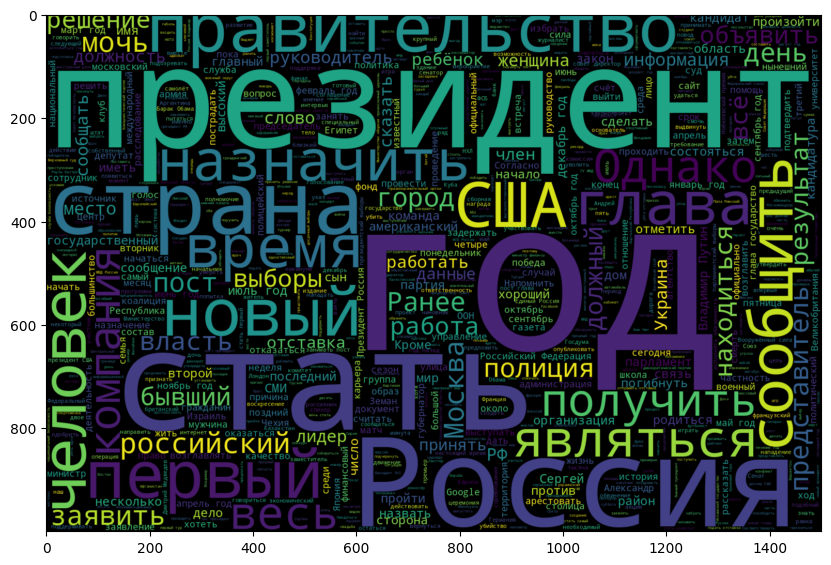

In [ ]:
all_text = ' '.join([' '.join(seq) for seq in df_processed['sequences']])

wordcloud = WordCloud(max_words=800, width=1500, height=1000).generate(all_text)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation='bilinear')

# Правила

In [ ]:
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

def apply_parser(entity_type, entity_to_ids, df, parser):
    b_id = entity_to_ids[entity_type]['B']
    i_id = entity_to_ids[entity_type]['I']

    all_results = []

    for idx, row in df.iterrows():
        sequences = row['sequences']
        true_ids = [int(x) for x in row['ids']]

        text = ' '.join(sequences)
        matches = list(parser.findall(text))
        pred_ids = [0] * len(true_ids)

        for match in matches:
            span = match.span
            start, end = span.start, span.stop

            current_pos = 0
            token_indices = []

            for i, token in enumerate(sequences):
                token_start = current_pos
                token_end = current_pos + len(token)

                if not (token_end <= start or token_start >= end):
                    token_indices.append(i)

                current_pos += len(token) + 1

            if token_indices:
                pred_ids[token_indices[0]] = b_id
                for idx in token_indices[1:]:
                    if idx < len(pred_ids):
                        pred_ids[idx] = i_id

        all_results.append({
            'true_ids': true_ids,
            'pred_ids': pred_ids,
            'sequences': sequences
        })

    return all_results

def build_heatmap(entity_type, entity_to_ids, results):
    b_id = entity_to_ids[entity_type]['B']
    i_id = entity_to_ids[entity_type]['I']

    all_true = []
    all_pred = []

    for result in results:
        true_ids = result['true_ids']
        pred_ids = result['pred_ids']

        for true, pred in zip(true_ids, pred_ids):
            true_label = mapper.get(true, 'O')
            pred_label = mapper.get(pred, 'O')

            if (true_label in [f'B-{entity_type}', f'I-{entity_type}', 'O'] and
                pred_label in [f'B-{entity_type}', f'I-{entity_type}', 'O']):
                all_true.append(true_label)
                all_pred.append(pred_label)

    labels = [f'B-{entity_type}', f'I-{entity_type}', 'O']
    cm = confusion_matrix(all_true, all_pred, labels=labels)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.title(f'Heatmap для {entity_type}')
    plt.ylabel('Истинные метки')
    plt.xlabel('Предсказанные метки')
    plt.show()

    print("Classification Report:")
    print(classification_report(all_true, all_pred, labels=labels))

    return cm

In [ ]:
entity_to_ids = {
            'PERSON': {'B': 44, 'I': 45},
            'DATE': {'B': 11, 'I': 12},
            'COUNTRY': {'B': 7, 'I': 8},
            'CITY': {'B': 5, 'I': 6},
            'STATE_OR_PROVINCE': {'B': 52, 'I': 53},
            'ORGANIZATION': {'B': 38, 'I': 39},
            'NATIONALITY': {'B': 32, 'I': 33},
            'EVENT': {'B': 17, 'I': 18},
            'RELIGION': {'B': 50, 'I': 51},
            'PROFESSION': {'B': 48, 'I': 49}
        }

Основные сущности, которые мы пытались находить

In [ ]:
from yargy.predicates import Predicate

# Проверка являются ли все буквы в слове заглавными
class AllCaps(Predicate):
    def __call__(self, token):
        return token.value.isalpha() and token.value.isupper()

## Date

In [ ]:
Date = fact('Date', ['part1', 'part2'])

DATE_COMPONENTS = or_(
    rule(morph_pipeline(['в', 'на', 'с', 'со', 'по', 'до', 'после', 'перед', 'за', 'к', 'от'])),

    rule(type('INT')),
    rule(gram('Anum')),

    rule(morph_pipeline([
        'январь', 'февраль', 'март', 'апрель', 'май', 'июнь',
        'июль', 'август', 'сентябрь', 'октябрь', 'ноябрь', 'декабрь'
    ])),

    rule(morph_pipeline([
        'понедельник', 'вторник', 'среда', 'четверг', 'пятница', 'суббота', 'воскресенье'
    ])),

    rule(morph_pipeline([
        'год', 'месяц', 'день', 'неделя', 'час', 'минута', 'секунда',
        'утро', 'вечер', 'ночь', 'день', 'полдень', 'полночь'
    ])),

    rule(normalized('сегодня')),
    rule(normalized('завтра')),
    rule(normalized('вчера')),
    rule(normalized('сейчас')),
    rule(normalized('текущий')),
    rule(normalized('прошлый')),
    rule(normalized('следующий')),

    rule(normalized('число')),
    rule(normalized('дата')),
    rule(normalized('время')),
    rule(normalized('период')),
    rule(normalized('момент')),
)

DATE_PART1 = DATE_COMPONENTS.interpretation(Date.part1)
DATE_PART2 = DATE_COMPONENTS.interpretation(Date.part2)

DATE = or_(
    rule(DATE_PART1, DATE_PART2, DATE_PART2, DATE_PART2, DATE_PART2, DATE_PART2, DATE_PART2, DATE_PART2, DATE_PART2, DATE_PART2, DATE_PART2),
    rule(DATE_PART1, DATE_PART2, DATE_PART2, DATE_PART2, DATE_PART2, DATE_PART2, DATE_PART2, DATE_PART2, DATE_PART2, DATE_PART2),
    rule(DATE_PART1, DATE_PART2, DATE_PART2, DATE_PART2, DATE_PART2, DATE_PART2, DATE_PART2, DATE_PART2, DATE_PART2),
    rule(DATE_PART1, DATE_PART2, DATE_PART2, DATE_PART2, DATE_PART2, DATE_PART2, DATE_PART2, DATE_PART2),
    rule(DATE_PART1, DATE_PART2, DATE_PART2, DATE_PART2, DATE_PART2, DATE_PART2, DATE_PART2),
    rule(DATE_PART1, DATE_PART2, DATE_PART2, DATE_PART2, DATE_PART2, DATE_PART2),
    rule(DATE_PART1, DATE_PART2, DATE_PART2, DATE_PART2, DATE_PART2),
    rule(DATE_PART1, DATE_PART2, DATE_PART2, DATE_PART2),
    rule(DATE_PART1, DATE_PART2, DATE_PART2),
    rule(DATE_PART1, DATE_PART2)
).interpretation(Date)


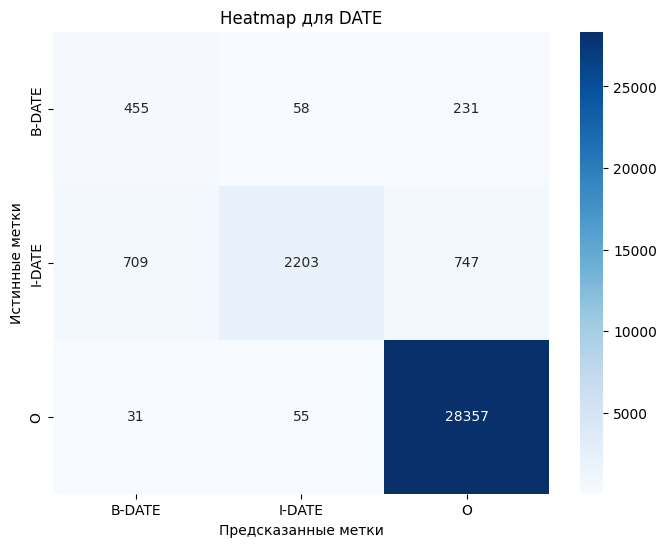

Classification Report:
              precision    recall  f1-score   support

      B-DATE       0.38      0.61      0.47       744
      I-DATE       0.95      0.60      0.74      3659
           O       0.97      1.00      0.98     28443

    accuracy                           0.94     32846
   macro avg       0.77      0.74      0.73     32846
weighted avg       0.95      0.94      0.94     32846



array([[  455,    58,   231],
       [  709,  2203,   747],
       [   31,    55, 28357]])

In [ ]:
date_parser = Parser(DATE)
results = apply_parser('DATE', entity_to_ids, df_processed, date_parser)
build_heatmap('DATE', entity_to_ids, results)

Правило достаточно хорошо справляется с поиском дат, особенно I-Date и особо нет ложных срабатываний

## County, Region, City

In [ ]:
def load_names(file_path: str, column: str = 'name'):
    df = pd.read_csv(file_path, sep=';', dtype=str, encoding='cp1251')
    df = df[column].dropna().unique()
    # убираем возможные кавычки, пробелы
    return [name.strip().replace('"', '') for name in df]

In [ ]:
COUNTRIES = load_names('https://raw.githubusercontent.com/CaptainNH/NLP_lab1/main/country.csv')
REGIONS = load_names('https://raw.githubusercontent.com/CaptainNH/NLP_lab1/main/region.csv')
CITIES = load_names('https://raw.githubusercontent.com/CaptainNH/NLP_lab1/main/city.csv')
REGION_NAMES_SET = set(REGIONS)
COUNTRIES_NAMES_SET = set(COUNTRIES)
CITIES_NAMES_SET = set(CITIES)

Для поиска различных локаций используется база стран, городов и регионов на русском языке. Источник - https://habr.com/ru/articles/21949/

In [ ]:
Country = fact('Country', ['name'])

COUNTRY_NAMES = or_(
    and_(is_capitalized(), dictionary(COUNTRIES_NAMES_SET), not_(dictionary(REGION_NAMES_SET)), not_(dictionary(CITIES_NAMES_SET))),
    and_(is_capitalized(), gram('Geox'), not_(gram('Surn')), not_(gram('Patr')), not_(gram('Name')),
         not_(dictionary(REGION_NAMES_SET)), not_(dictionary(CITIES_NAMES_SET)))
)

GEO_WORDS = morph_pipeline(['страна'])
PREP_GEO = morph_pipeline(['в', 'из', 'на', 'по', 'около', 'возле', 'для'])

COUNTRY_RULE = or_(
    rule(PREP_GEO, COUNTRY_NAMES),
    rule(COUNTRY_NAMES, GEO_WORDS),
    rule(GEO_WORDS, COUNTRY_NAMES),
    rule(PREP_GEO, GEO_WORDS, COUNTRY_NAMES),
    rule(COUNTRY_NAMES),
    # rule(and_(gram('Geox'), not_(dictionary(REGION_NAMES_SET)), not_(dictionary(CITIES_NAMES_SET))))
).interpretation(Country.name)

country_parser = Parser(COUNTRY_RULE)

In [ ]:
State = fact('State', ['name'])


STATE_COMPONENTS = or_(
    and_(is_capitalized(), dictionary(REGION_NAMES_SET), not_(dictionary(COUNTRIES_NAMES_SET)), not_(dictionary(CITIES_NAMES_SET))),
    # and_(is_capitalized(), gram('Geox'), not_(gram('Surn')), not_(gram('Patr')), not_(gram('Name')),
    #   not_(dictionary(COUNTRIES_NAMES_SET)), not_(dictionary(CITIES_NAMES_SET)))
)

STATE_NAME = STATE_COMPONENTS.interpretation(State.name)

STATE_SINGLE = rule(STATE_NAME)
STATE_DOUBLE = rule(STATE_NAME, STATE_NAME)
STATE_TRIPLE = rule(STATE_NAME, STATE_NAME, STATE_NAME)

STATE_RULE = or_(
    STATE_SINGLE,
    STATE_DOUBLE,
    STATE_TRIPLE,
    # rule(and_(gram('Geox'), not_(dictionary(COUNTRIES_NAMES_SET)), not_(dictionary(CITIES_NAMES_SET))))
).interpretation(State.name)

state_parser = Parser(STATE_RULE)


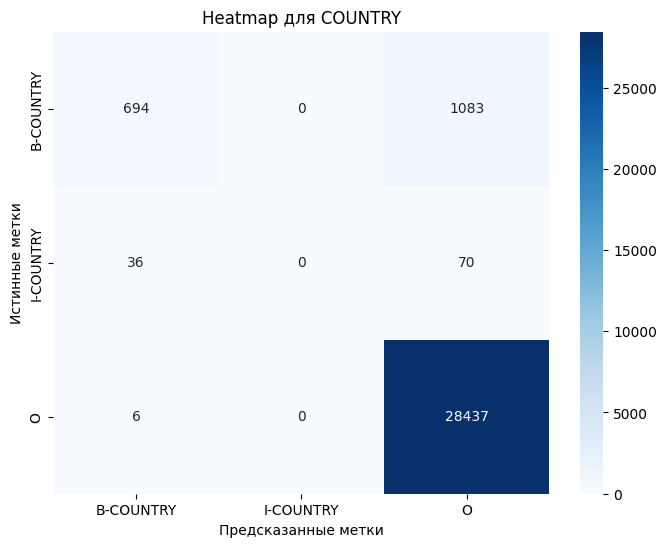

Classification Report:
              precision    recall  f1-score   support

   B-COUNTRY       0.94      0.39      0.55      1777
   I-COUNTRY       0.00      0.00      0.00       106
           O       0.96      1.00      0.98     28443

    accuracy                           0.96     30326
   macro avg       0.63      0.46      0.51     30326
weighted avg       0.96      0.96      0.95     30326



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


array([[  694,     0,  1083],
       [   36,     0,    70],
       [    6,     0, 28437]])

In [ ]:
results = apply_parser('COUNTRY', entity_to_ids, df_processed, country_parser)
build_heatmap('COUNTRY', entity_to_ids, results)

Если вернуть закомментированный бейзлайн распознавание именно стран будет чуть лучше, но сильно конфликтует с другими сущностями, такими как имена, организации и тд, поэтому было решено использовать только свои правила.

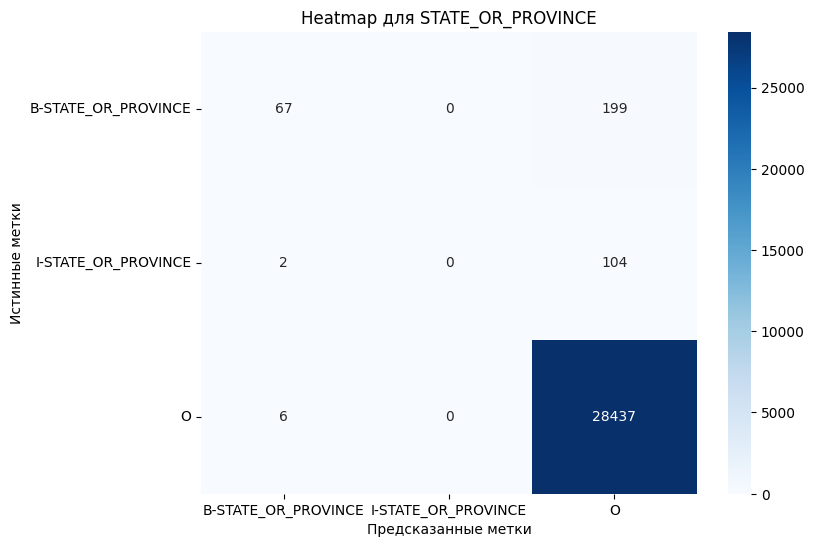

Classification Report:
                     precision    recall  f1-score   support

B-STATE_OR_PROVINCE       0.89      0.25      0.39       266
I-STATE_OR_PROVINCE       0.00      0.00      0.00       106
                  O       0.99      1.00      0.99     28443

           accuracy                           0.99     28815
          macro avg       0.63      0.42      0.46     28815
       weighted avg       0.98      0.99      0.99     28815



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


array([[   67,     0,   199],
       [    2,     0,   104],
       [    6,     0, 28437]])

In [ ]:
results = apply_parser('STATE_OR_PROVINCE', entity_to_ids, df_processed, state_parser)
build_heatmap('STATE_OR_PROVINCE', entity_to_ids, results)

С регионами в целом проблема аналогичная правилу со странами

In [ ]:
City = fact('City', ['name'])

CITY_NAMES = or_(
    and_(is_capitalized(), dictionary(CITIES_NAMES_SET), not_(dictionary(REGION_NAMES_SET)), not_(dictionary(COUNTRIES_NAMES_SET))),
    # and_(is_capitalized(), gram('Geox'), not_(gram('Surn')), not_(gram('Patr')), not_(gram('Name')),
    #      not_(dictionary(REGION_NAMES_SET)), not_(dictionary(COUNTRIES_NAMES_SET)))
)

GEO_WORDS = morph_pipeline(['город'])
PREP_GEO = morph_pipeline(['в', 'из', 'на', 'по', 'около', 'возле', 'для'])

CITY_RULE = or_(
    rule(PREP_GEO, CITY_NAMES),
    rule(CITY_NAMES, GEO_WORDS),
    rule(GEO_WORDS, CITY_NAMES),
    rule(PREP_GEO, GEO_WORDS, CITY_NAMES),
    rule(CITY_NAMES),
    # rule(and_(gram('Geox'), not_(dictionary(REGION_NAMES_SET)), not_(dictionary(COUNTRIES_NAMES_SET))))
).interpretation(Country.name)

city_parser = Parser(CITY_RULE)

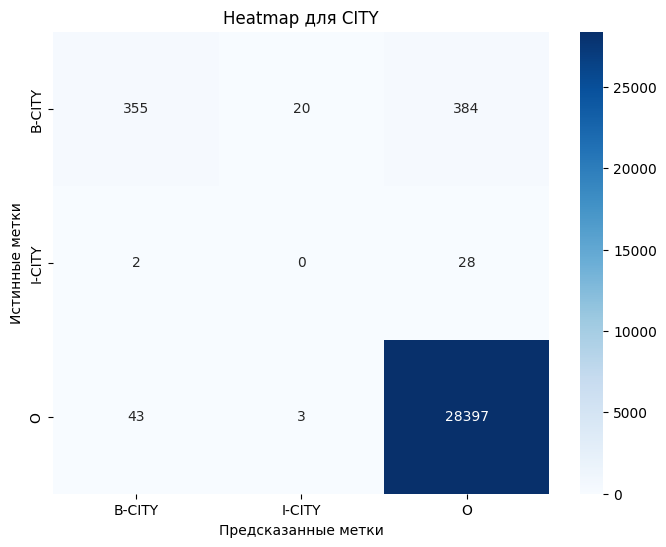

Classification Report:
              precision    recall  f1-score   support

      B-CITY       0.89      0.47      0.61       759
      I-CITY       0.00      0.00      0.00        30
           O       0.99      1.00      0.99     28443

    accuracy                           0.98     29232
   macro avg       0.62      0.49      0.53     29232
weighted avg       0.98      0.98      0.98     29232



array([[  355,    20,   384],
       [    2,     0,    28],
       [   43,     3, 28397]])

In [ ]:
results = apply_parser('CITY', entity_to_ids, df_processed, city_parser)
build_heatmap('CITY', entity_to_ids, results)

С городами тоже есть та же проблема, но подход справляется чуть лучше чем в случае стран и регионов, потому что список городов в базе сильно больше, чем стран или регионов.

### Person

In [ ]:
geo_words_set = set(COUNTRIES + REGIONS + CITIES)

In [ ]:
Person = fact('Person', ['first', 'last'])

# NAME_COMPONENTS = or_(and_(gram('Surn'), is_capitalized()),
#            and_(gram('Patr'), is_capitalized()),
#            and_(gram('Name'), is_capitalized())
# )
# FIRST = NAME_COMPONENTS.interpretation(Person.first)
# LAST = NAME_COMPONENTS.interpretation(Person.first)

NAME_COMPONENTS = or_(
    and_(gram('Surn'), is_capitalized(), not_(dictionary(geo_words_set)), not_(AllCaps()), not_(gram('Geox'))),
    and_(gram('Patr'), is_capitalized(), not_(dictionary(geo_words_set)), not_(AllCaps()), not_(gram('Geox'))),
    and_(gram('Name'), is_capitalized(), not_(dictionary(geo_words_set)), not_(AllCaps()), not_(gram('Geox')))
)

FIRST = NAME_COMPONENTS.interpretation(Person.first)
LAST = NAME_COMPONENTS.interpretation(Person.first)

PERSON_FIRST_ONLY = rule(FIRST).interpretation(Person)
PERSON_BASIC = rule(FIRST, LAST).interpretation(Person)
PERSON3 = rule(FIRST, LAST, LAST).interpretation(Person)
PERSON4 = rule(FIRST, LAST, LAST, LAST).interpretation(Person)

TITLE = morph_pipeline(['господин', 'товарищ', 'доктор'])
PERSON_WITH_TITLE1 = rule(TITLE, FIRST, LAST).interpretation(Person)
PERSON_WITH_TITLE2 = rule(TITLE, FIRST).interpretation(Person)

INITIAL = rule(gram('Init'))
PERSON_WITH_INITIAL1 = rule(FIRST, INITIAL).interpretation(Person)
PERSON_WITH_INITIAL2 = rule(INITIAL, FIRST).interpretation(Person)

PERSON = or_(
    PERSON_BASIC,
    PERSON3,
    PERSON4,
    PERSON_WITH_TITLE1,
    PERSON_WITH_TITLE2,
    PERSON_WITH_INITIAL1,
    PERSON_WITH_INITIAL2,
    PERSON_FIRST_ONLY
).interpretation(Person)

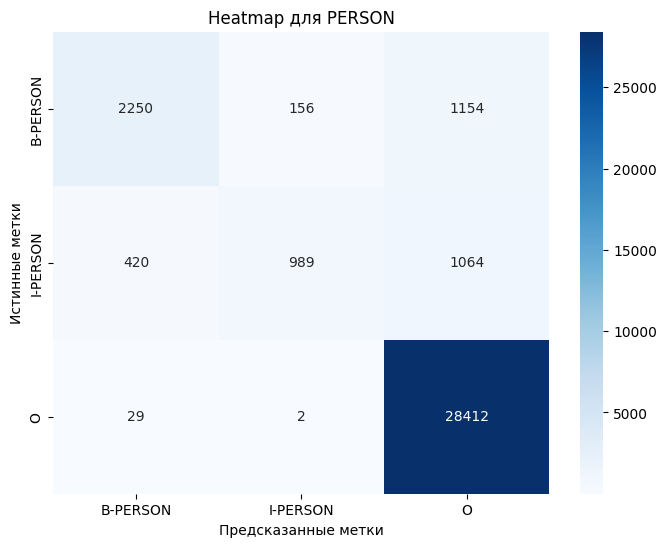

Classification Report:
              precision    recall  f1-score   support

    B-PERSON       0.83      0.63      0.72      3560
    I-PERSON       0.86      0.40      0.55      2473
           O       0.93      1.00      0.96     28443

    accuracy                           0.92     34476
   macro avg       0.87      0.68      0.74     34476
weighted avg       0.91      0.92      0.91     34476



array([[ 2250,   156,  1154],
       [  420,   989,  1064],
       [   29,     2, 28412]])

In [ ]:
person_parser = Parser(PERSON)
results = apply_parser('PERSON', entity_to_ids, df_processed, person_parser)
build_heatmap('PERSON', entity_to_ids, results)

В правиле для поиска людей мы не учитываем слова подходящие под описание географических локаций и слова состоящие из всех заглавных букв, т.к. это вызывало конфликты с локациями и организациями. Без этого оно работало чуть лучше именно для поиска людей, но это сделано в пользу решения конфликтов с пересечениями сущностей, а изменения не такие значительные и в целом правило находит людей достаточно хорошо.

### Religion

In [ ]:
Religion = fact('Religion', ['name', 'type'])

RELIGIONS = morph_pipeline([
    'христианство', 'буддизм', 'иудаизм', 'индуизм', 'конфуцианство',
    'мусульманин', 'христианин', 'буддист', 'иудей', 'индуист'
])

RELIGIOUS_CONTEXT = morph_pipeline([
    'вера', 'религия', 'церковь', 'мечеть', 'храм', 'синагога', 'молиться',
    'исповедовать', 'практиковать'
])

PREP_RELIGION = morph_pipeline(['в', 'из', 'принадлежащий', 'по', 'для'])

RELIGION_RULE = or_(
    rule(PREP_RELIGION.optional(), RELIGIOUS_CONTEXT.optional(), RELIGIONS),
    rule(RELIGIONS)
).interpretation(Religion.name)

religion_parser = Parser(RELIGION_RULE)

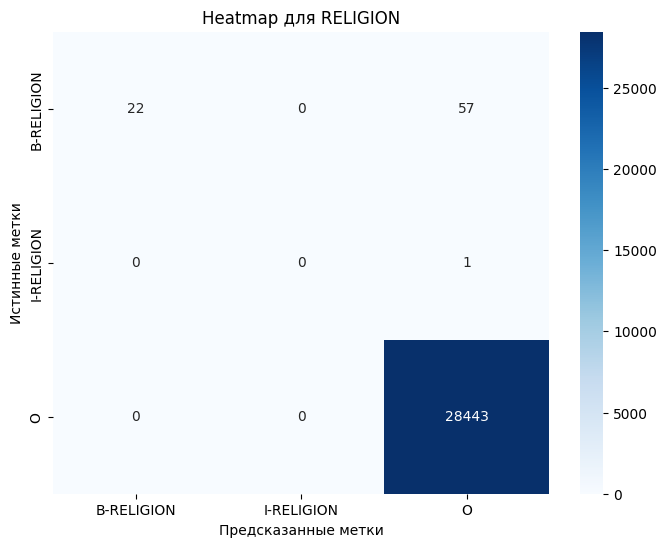

Classification Report:


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

  B-RELIGION       1.00      0.28      0.44        79
  I-RELIGION       0.00      0.00      0.00         1
           O       1.00      1.00      1.00     28443

    accuracy                           1.00     28523
   macro avg       0.67      0.43      0.48     28523
weighted avg       1.00      1.00      1.00     28523



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


array([[   22,     0,    57],
       [    0,     0,     1],
       [    0,     0, 28443]])

In [ ]:
results = apply_parser('RELIGION', entity_to_ids, df_processed, religion_parser)
build_heatmap('RELIGION', entity_to_ids, results)

Скорее всего, если увеличить базу слов, будет работать лучше. Но т.к. религий в датасете в целом мало, мы решили оставить так и попытаться улучшить поиск других сущностей.

### Organization

In [ ]:
from yargy import or_
from yargy.predicates import length_eq

def length_range(min_len: int, max_len: int):
    """
    Возвращает предикат (or_(length_eq(min_len), length_eq(min_len+1), ...)).
    Используй, если хочешь избежать кастомных предикатов.
    """
    preds = [length_eq(i) for i in range(min_len, max_len + 1)]
    return or_(*preds)


In [ ]:
from yargy import rule, or_, and_
from yargy.predicates import gram, is_capitalized, dictionary, in_caseless, eq
from yargy.pipelines import morph_pipeline

Organization = fact('Organization', ['name'])

ORG_WORDS = morph_pipeline([
    'компания', 'фирма', 'организация', 'министерство', 'управление',
    'правительство', 'полиция', 'университет', 'институт', 'банк', 'корпорация',
    'фонд', 'партия', 'совет', 'ассоциация', 'комитет', 'ведомство', 'служба'
])

ORG_ADJ = morph_pipeline(['главный', 'федеральный', 'народный', 'национальный'])

ABBREV = and_(
    AllCaps(),
    length_range(2, 5)
)

LATIN = gram('LATN')

ORG_RULE = or_(
    # rule(ORG_WORDS, is_capitalized()),
    # rule(ABBREV, is_capitalized()),
    rule(and_(ABBREV,not_(dictionary(geo_words_set)), not_(gram('Geox')))),
    rule(ORG_WORDS, ORG_ADJ.optional()),
    rule(LATIN, in_caseless({'of', 'and'}).optional(), LATIN),
    rule(ORG_WORDS),
    rule(and_(gram('Orgn'), not_(gram('Geox')), not_(gram('Name')), not_(gram('Surn')), not_(gram('Patr')),
              not_(dictionary(geo_words_set))))
).interpretation(Organization.name)
organization_parser = Parser(ORG_RULE)


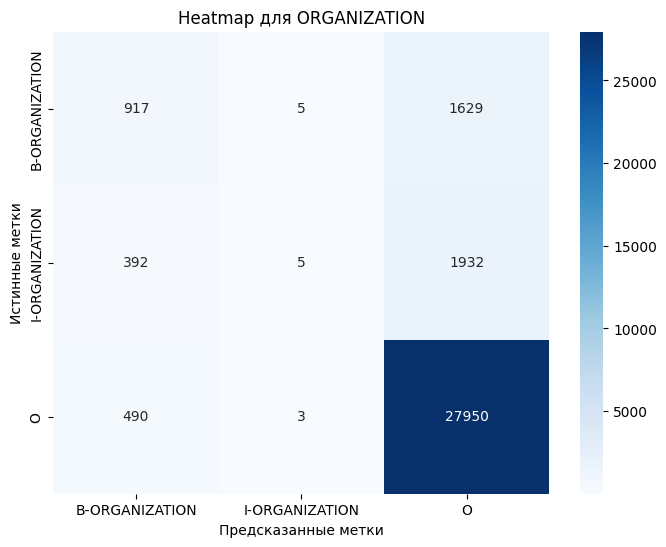

Classification Report:
                precision    recall  f1-score   support

B-ORGANIZATION       0.51      0.36      0.42      2551
I-ORGANIZATION       0.38      0.00      0.00      2329
             O       0.89      0.98      0.93     28443

      accuracy                           0.87     33323
     macro avg       0.59      0.45      0.45     33323
  weighted avg       0.82      0.87      0.83     33323



array([[  917,     5,  1629],
       [  392,     5,  1932],
       [  490,     3, 27950]])

In [ ]:
results = apply_parser('ORGANIZATION', entity_to_ids, df_processed, organization_parser)
build_heatmap('ORGANIZATION', entity_to_ids, results)

В целом можно сказать, что правила неплохо распознают одиночные и очевидные названия организаций, а также аббревиатуры. Но слабо справляются со сложными названиями, особенно когда они состоят из нескольких токенов. Для улучшения можно попробовать добавить больше контекстных слов, расширить базовый список слов.

In [ ]:
from yargy import rule, or_, and_
from yargy.predicates import gram, dictionary, is_capitalized, in_caseless, normalized
from yargy.pipelines import morph_pipeline
from yargy.interpretation import fact
from yargy.parser import Parser

Profession = fact('Profession', ['name'])

PROFESSIONS = [
    'президент', 'министр', 'директор', 'начальник', 'командир', 'офицер', 'капитан',
    'генерал', 'адмирал', 'врач', 'доктор', 'учитель', 'профессор', 'доцент',
    'инженер', 'разработчик', 'программист', 'журналист', 'редактор', 'ведущий',
    'актёр', 'певец', 'спортсмен', 'тренер', 'менеджер', 'консультант',
    'экономист', 'юрист', 'адвокат', 'судья', 'полицейский', 'следователь',
    'бизнесмен', 'предприниматель', 'премьер-министр', 'премьер', 'глава'
]

PROF_WORDS = dictionary({w.lower() for w in PROFESSIONS})

PROF_CONTEXT = morph_pipeline([
    'ведущий', 'старший', 'бывший', 'опытный',
    'знаменитый', 'военный', 'технический'
])

PROF_RULE = or_(
    rule(PROF_WORDS),
    rule(PROF_CONTEXT, PROF_WORDS),
    rule(PROF_WORDS, in_caseless({'-', '–'}), PROF_WORDS),
    # rule(PROF_WORDS, is_capitalized().optional()),
    # rule(and_(not_(dictionary(geo_words_set)), is_capitalized()), PROF_WORDS),
    rule(PROF_WORDS, PROF_WORDS),
    rule(PROF_WORDS, PROF_CONTEXT),
    # rule(PROF_WORDS, and_(gram('NOUN'), is_capitalized())),
    # rule(PROF_WORDS),
    rule(PROF_CONTEXT),
    # rule(gram('ADJF'), gram('NOUN')),
).interpretation(Profession.name)

profession_parser = Parser(PROF_RULE)


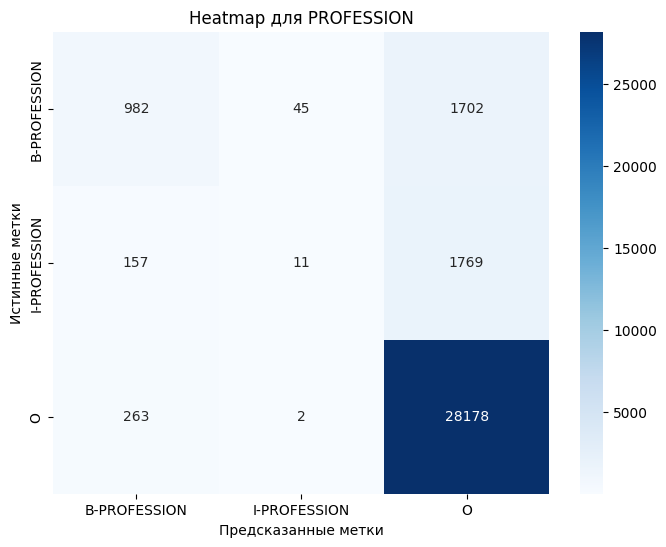

Classification Report:
              precision    recall  f1-score   support

B-PROFESSION       0.70      0.36      0.48      2729
I-PROFESSION       0.19      0.01      0.01      1937
           O       0.89      0.99      0.94     28443

    accuracy                           0.88     33109
   macro avg       0.59      0.45      0.47     33109
weighted avg       0.83      0.88      0.85     33109



array([[  982,    45,  1702],
       [  157,    11,  1769],
       [  263,     2, 28178]])

In [ ]:
results = apply_parser('PROFESSION', entity_to_ids, df_processed, profession_parser)
build_heatmap('PROFESSION', entity_to_ids, results)

Многие правила подходящие для профессий тоже конфликтовали с именами, организациями или географическими локациями. Из-за того что их закомментировали, распознавание стало сильно хуже и правило плохо различает сложные составные профессии. Можно попробовать для улучшения ввести отрицательный контекст и увеличить базу профессий.

# Проверка конфликтов

In [ ]:
def check_conflicts(parsers_dict, test_texts):
    conflicts = []

    for text in test_texts:
        found_entities = {}

        for entity_type, parser in parsers_dict.items():
            matches = list(parser.findall(text))
            if matches:
                found_entities[entity_type] = matches

        entities_list = []
        for entity_type, matches in found_entities.items():
            for match in matches:
                span = match.span
                entities_list.append({
                    'type': entity_type,
                    'span': span,
                    'text': text[span.start:span.stop]
                })

        for i, ent1 in enumerate(entities_list):
            for j, ent2 in enumerate(entities_list):
                if i != j:
                    span1 = ent1['span']
                    span2 = ent2['span']

                    if not (span1.stop <= span2.start or span2.stop <= span1.start):
                        conflicts.append({
                            'text': text,
                            'entity1': ent1,
                            'entity2': ent2,
                            'overlap': f"{text[min(span1.start, span2.start):max(span1.stop, span2.stop)]}"
                        })

    return conflicts

parsers_dict = {
    'PERSON': person_parser,
    'DATE': date_parser,
    'COUNTRY': country_parser,
    'STATE_OR_PROVINCE': state_parser,
    'CITY': city_parser,
    'RELIGION': religion_parser,
    'PROFESSION': profession_parser,
    'ORGANIZATION': organization_parser
}

test_texts = [
    ' '.join(row['sequences']) for row in df_processed.to_dict('records')
]

conflicts = check_conflicts(parsers_dict, test_texts)

print("=== ПРОВЕРКА КОНФЛИКТОВ ===")
if conflicts:
    print(f"Найдено конфликтов: {len(conflicts)}")
    for i, conflict in enumerate(conflicts[:5]):
        print(f"\nКонфликт {i+1}:")
        print(f"Текст: {conflict['text']}")
        print(f"Сущность 1: {conflict['entity1']['type']} - '{conflict['entity1']['text']}'")
        print(f"Сущность 2: {conflict['entity2']['type']} - '{conflict['entity2']['text']}'")
        print(f"Пересечение: '{conflict['overlap']}'")
else:
    print("Конфликтов не найдено!")

=== ПРОВЕРКА КОНФЛИКТОВ ===
Конфликтов не найдено!


В целом для улучшения качества распознавания всех сущностей скорее всего поможет ещё обучить нейронку